# 2. Do basic descriptive analysis

We wanted to analyse how many Parlimentary written questions could not be answered because the department did not have the requisite data, and what those questions were about.

We first obtained text for all the written answers in the current Parliament from TheyWorkForYou. 

In this notebook:

- we perform high-level analysis on this data to get a sense of how many questions are asked, who asks them, and how many of them are quantitative
- we identify common strings that may indicate questions that could not be answered due to lack of data
- we write these questions to separate files for manual review. 

We subsequently reviewed these questions manually, to see which of these questions were truly unanswered, and what themes recurred for each Department.

NB: The text of Hansard answers remains under [Parliamentary copyright](https://www.parliament.uk/site-information/copyright-parliament/).

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
df = pd.read_csv('./data/output/questions_with_flags.csv', low_memory=False)
len(df)

203938

## Examine question frequency over time

These largely seem to follow the [patterns of Parliamentary recess](https://www.parliament.uk/about/faqs/house-of-commons-faqs/business-faq-page/recess-dates/).

Note that a small number of questions were submitted prior to the period, but only answered later - this doesn't matter for the purpose of our analysis. Note also that this dataset only contains answered questions, there may be others that haven't been answered yet.

In [24]:
df.date_submitted = pd.to_datetime(df.date_submitted)
df.date_answered = pd.to_datetime(df.date_answered)

<Axes: title={'center': 'Count of questions answered by month'}, xlabel='date_answered,date_answered'>

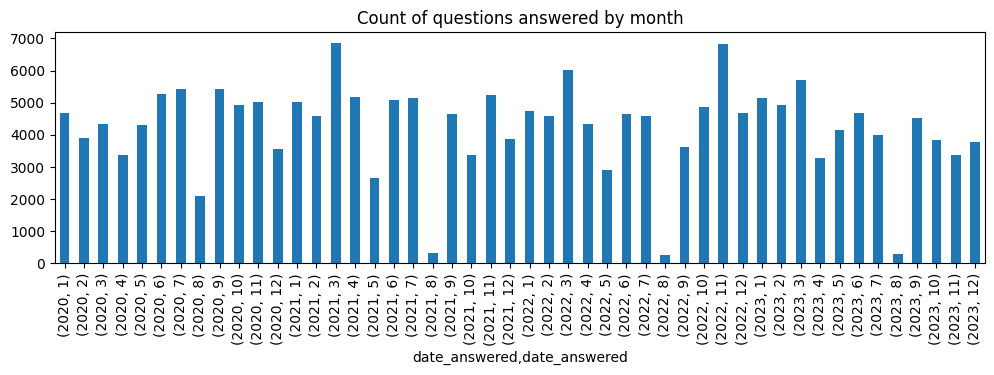

In [25]:
df.groupby([df.date_answered.dt.year, df.date_answered.dt.month]).url.size()\
    .plot(kind="bar", title="Count of questions answered by month", figsize=(12, 3))

## Which departments get asked most WQs?

DHSC by a factor of two - even before Covid. Note there were departmental splits and merges over the period, particularly in BEIS.

In [26]:
pd.concat([df.department.value_counts().head(10), 
           df.department.value_counts(normalize=True).head(10) * 100], 
          axis=1)

,count,proportion
department,,
Department of Health and Social Care,39376,19.308018
"Foreign, Commonwealth and Development Office",17440,8.551702
Home Office,16181,7.934352
Department for Transport,13696,6.715832
"Department for Business, Energy and Industrial Strategy",13569,6.653558
Department for Education,13135,6.440746
Treasury,12138,5.951867
"Department for Environment, Food and Rural Affairs",11219,5.501236
Department for Work and Pensions,10708,5.250667


Chart questions to each major department, by month. 

<Axes: xlabel='date_submitted,date_submitted'>

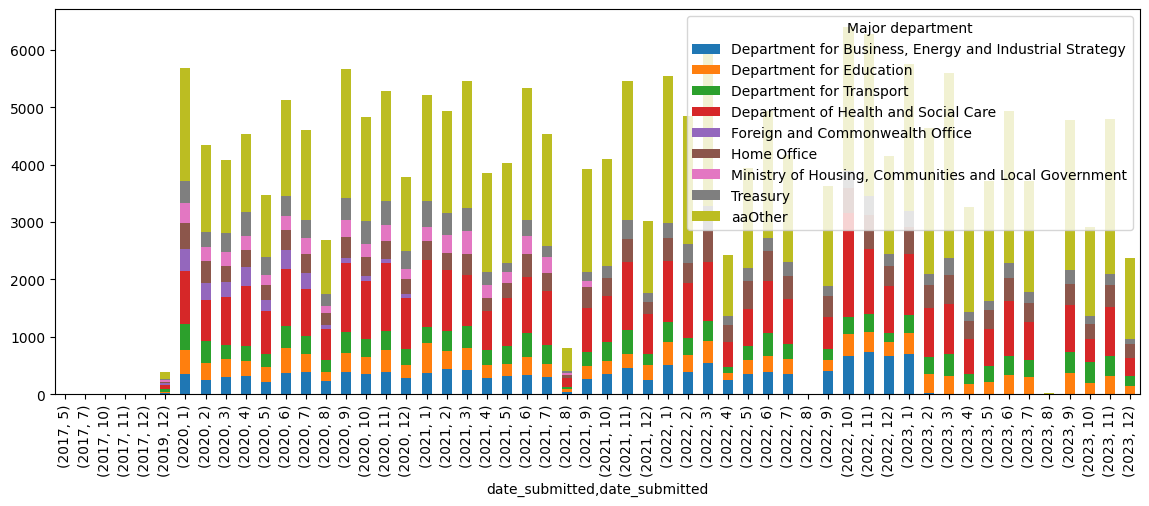

In [27]:
def get_major_department(dept):
    if dept != 'Department of Health and Social Care' \
        and dept != 'Home Office' \
        and dept != 'Treasury'\
        and dept != 'Department for Transport' \
        and dept != 'Department for Education'\
        and dept != 'Foreign and Commonwealth Office' \
        and dept != 'Department for Business, Energy and Industrial Strategy' \
        and dept != 'Ministry of Housing, Communities and Local Government':
        return 'aaOther'
    return dept
df['Major department'] = df.department.apply(get_major_department)
df.groupby([df.date_submitted.dt.year, df.date_submitted.dt.month, df['Major department']]).url.count()\
    .unstack(level=-1) \
    .plot(kind="bar", stacked=True, figsize=(14,5))

## Who asks the most WQs?

Shadow ministers tend to ask lots, unsurprisingly. Some opposition backbenchers can be very active too.

In [28]:
print(len(df.question_speaker.value_counts()), "people asked questions over the period")

1163 people asked questions over the period


In [29]:
df.groupby(['question_speaker', 'question_position']).url.count().sort_values(ascending=False).head(10)

question_speaker        question_position                                                       
Rachael Maskell         Labour/Co-operative, York Central                                           3961
John Healey             Shadow Secretary of State for Defence                                       2729
Jim Shannon             Shadow DUP Spokesperson (Human Rights), Shadow DUP Spokesperson (Health)    2702
Tan Dhesi               Shadow Minister (Transport)                                                 2220
Rachael Maskell         Shadow Minister (Digital, Culture, Media and Sport)                         2076
Caroline Lucas          Green, Brighton, Pavilion                                                   2062
Kevan Jones             Labour, North Durham                                                        2029
Matthew Offord          Conservative, Hendon                                                        1898
Andrew Rosindell        Conservative, Romford                  

## Utility: Save a particular department's WQs, to read

Convenience code for outputing a particular department's WQs, without superfluous columns.

In [32]:
df.question_text = df.question_text.str.strip()
cols_in_order = [
    'title', 'url',
    'question_text', 'answer_text',
    'is_quantitative', 'contains_not_held_string',
    'contains_not_held_string_and_isquant',
    'contains_not_possible_string',
    'date_submitted', 'date_answered',
    'question_speaker', 'question_position',
    'answer_speaker', 'answer_position',
]

In [36]:
department = {
    "name": "Department of Health and Social Care",
    "acronym": "dhsc"
}

df_for_department = df[(df.department == department['name'])][cols_in_order]
df_for_department.to_csv('./data/by_department/%s.csv' % department['acronym'], index=False)

In [43]:
print(len(df_for_department), "questions to %s in this Parliament" % department['name'])
print(len(df_for_department[df_for_department.is_quantitative]), "were quantitative")
print(len(df_for_department[df_for_department.contains_not_held_string_and_isquant]), "of those were marked as unanswered")

39376 questions to Department of Health and Social Care in this Parliament
6659 were quantitative
2806 of those were marked as unanswered
